# Inference of the Empirical Bohr Parameter

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
import altair as alt
import pystan
import bebi103.viz
import bokeh.io
bokeh.io.output_notebook()
constants = mut.thermo.load_constants()
colors = mut.viz.personal_style()
%load_ext stanmagic

Loading BokehJS ...

The fold-change in gene expression can be written as

$$
\text{fold-change}  = {1 \over 1 + e^{\beta F}}.
$$

Given a measurement of fold-change, the experimentally observed value for the Bohr parameter can be calculated as 

$$
\text{F_{meas}} = \log\left({1 \over \text{fold-change}} - 1\right)
$$

For theoretical considerations, this formualtion is fine. Experimentally, however, it is possible to have measurements of fold-change $\geq 1$ or $\leq 0$ due to measurement noise. This makes inference of the empirical $\Delta F$ difficult as $F_{meas}$ cannot be calculated directly. 

The purpose of this notebook is to work out some inferential scheme to determine the best estimate of $F_{meas}$.

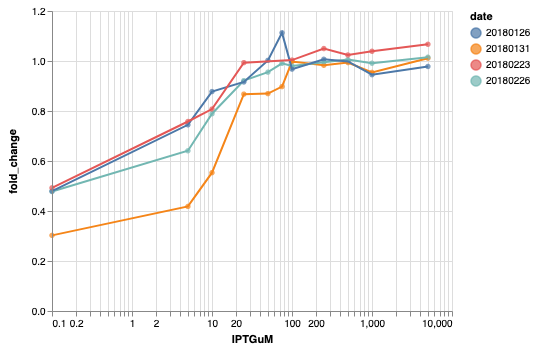

In [2]:
# Load the data and isolate a representative mutant. 
data = pd.read_csv('../../data/csv/compiled_data.csv')
Y20I = data[(data['mutant']=='Y20I') & (data['repressors'] == 260) & (data['operator']=='O2')]

# Plot the data set to see if it makes sense. 
Y20I_chart = alt.Chart(data=Y20I[Y20I['IPTGuM'] > 0])
Y20I_points = Y20I_chart.mark_point(filled=True).encode( 
    x=alt.X('IPTGuM:Q', scale={'type':'log'}), 
    y='fold_change:Q', color='date:N')

Y20I_lines = Y20I_chart.mark_line().encode(
    x='IPTGuM:Q', y='fold_change:Q', color='date:N')

Y20I_points + Y20I_lines

In [3]:
%%stan -v empirical_F
data {
    int<lower=1> N; // Number of measurements
    int<lower=1> J; // Number of IPTG concentrations
    int<lower=1, upper=J> idx[N]; // ID vector for IPTG concentration
    vector[N] fc;
}

parameters {
    vector<lower=0, upper=1>[J] fc_mu;
    real<lower=0> sigma; 
}

model { 
    // Set the priors. 
    fc_mu ~ uniform(0, 1);
    sigma ~ normal(0, 0.1);    
    fc[idx] ~ normal(fc_mu[idx], sigma);
}

generated quantities {
    real F[J];
    for (i in 1:J) {
        F[i] = log((1/fc_mu[i]) - 1);
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in empirical_F object.
Type empirical_F in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
empirical_F.model_file -> Name of stan_file [None]
empirical_F.model_name -> Name of stan model [None]
empirical_F.model_code -> Model code [data {     int<lower ....]


In [ ]:
model = pystan.StanModel(model_code=empirical_F.model_code)

In [5]:
Y20I['idx'] = Y20I.groupby(['IPTGuM']).ngroup() + 1
data_dict = {'N':len(Y20I), 'J':Y20I['idx'].max(), 'idx':Y20I['idx'], 'fc':Y20I['fold_change']}
sampling = model.sampling(data_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
# Define the reference architecture. 
c_0 = 50
ref = mut.thermo.SimpleRepression(R= Y20I['repressors'],
                                      ep_r=constants['O2'],
                                      ka=constants['Ka'],
                                      ki = constants['Ki'],
                                      ep_ai = constants['ep_AI'],
                                      effector_conc=c_0)

In [8]:
sampling

Inference for Stan model: anon_model_fe7ef79eb64095cf1f50ae9b90d2b161.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
fc_mu[1]     0.5  3.1e-5 2.1e-3    0.5    0.5    0.5   0.51   0.51   4490    1.0
fc_mu[2]     0.3  3.2e-5 2.1e-3    0.3    0.3    0.3    0.3   0.31   4333    1.0
fc_mu[3]    0.42  3.0e-5 2.0e-3   0.41   0.42   0.42   0.42   0.42   4583    1.0
fc_mu[4]    0.55  3.0e-5 2.1e-3   0.55   0.55   0.55   0.55   0.56   4724    1.0
fc_mu[5]    0.87  3.3e-5 2.1e-3   0.86   0.87   0.87   0.87   0.87   4018    1.0
fc_mu[6]    0.87  4.0e-5 2.4e-3   0.86   0.87   0.87   0.87   0.87   3728    1.0
fc_mu[7]     0.9  3.5e-5 2.3e-3   0.89    0.9    0.9    0.9    0.9   4476    1.0
fc_mu[8]     1.0  2.5e-5 1.6e-3   0.99    1.0    1.0    1.0    1.0   4236    1.0
fc_mu[9]    0.98  3.5e-5 2.0e-3   0.98   0.98   0.98   0.98   0.99   3454    1.0
f

In [ ]:
# Generate the dataframe
df = sampling.to_dataframe()

# map IDX to IPTG concentration
idx_key = {idx:iptg for idx, iptg in zip(Y20I['idx'].unique(), Y20I['IPTGuM'].unique())}

# Plot the ECDFs for each measured F and fc_mu
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].set_xlabel('$\mu_\mathrm{fc}$')
ax[0].set_ylabel('cumulative distribution')
ax[1].set_xlabel('$F_\mathrm{measured}$ [$k_BT$]')
ax[1].set_ylabel('cumulative distribution')
for i in range(1, 12):
    fc = np.sort(df[f'fc_mu[{i}]'])
    F = np.sort(df[f'F[{i}]'])
    y = np.arange(0, len(df), 1) / len(df)    
    ax[0].step(fc, y, label=idx_key[i])
    ax[1].step(F, y, label=idx_key[i])
plt.tight_layout() 
plt.savefig('ecdfs.png', bbox_inches='tight')

In [ ]:
# Define the reference architecture. 
c_0 = 50
ref = mut.thermo.SimpleRepression(R= Y20I['repressors'],
                                      ep_r=constants['O2'],
                                      ka=constants['Ka'],
                                      ki = constants['Ki'],
                                      ep_ai = constants['ep_AI'],
                                      effector_conc=c_0)

wt = mut.thermo.SimpleRepression(R= Y20I['repressors'].unique(),
                                      ep_r=constants['O2'],
                                      ka=constants['Ka'],
                                      ki = constants['Ki'],
                                      ep_ai = constants['ep_AI'],
                                      effector_conc=Y20I['IPTGuM'].unique())
# Compute the empirical ddf. 
mean_df = df.mean()
empirical_df = -ref.bohr_parameter().unique() - mean_df
f_vars = [f'F[{i+1}]' for i in range(12)]

# Generate the data frame. 
summ_df = pd.DataFrame([], columns=['empirical_df', 'ddf', 'IPTGuM'])
summ_df['empirical_df'] = mean_df[f_vars]
summ_df['IPTGuM'] = Y20I['IPTGuM'].unique()
summ_df['ddf'] = summ_df['empirical_df'] - (-wt.bohr_parameter())

In [ ]:
plt.semilogx(summ_df['IPTGuM'], summ_df['ddf'], '-o')
plt.ylim([-8, 8])

Applying this to other mutants suggests this won't work. Can we infer $F$? 